In [1]:
import sys
print(sys.executable)

c:\Users\Atharva\RecycleVision\venv\Scripts\python.exe


In [2]:
import tensorflow as tf
print(tf.__version__)


2.15.0


In [3]:
import zipfile
import os

zip_path = "images.zip"

with zipfile.ZipFile(zip_path, "r") as zip_ref:
    zip_ref.extractall("dataset")

print("Extracted folders:", os.listdir("dataset"))

Extracted folders: ['Garbage classification', 'one-indexed-files-notrash_test.txt', 'one-indexed-files-notrash_train.txt', 'one-indexed-files-notrash_val.txt', 'one-indexed-files.txt', 'zero-indexed-files.txt']


In [4]:
!find dataset -maxdepth 2 -type d

FIND: Parameter format not correct


In [5]:
data_path = "dataset/RecycleVision"

In [6]:
import os
data_path = "dataset/Garbage classification/Garbage classification"
print(os.listdir(data_path))

['cardboard', 'glass', 'metal', 'paper', 'plastic', 'trash']


(-0.5, 511.5, 383.5, -0.5)

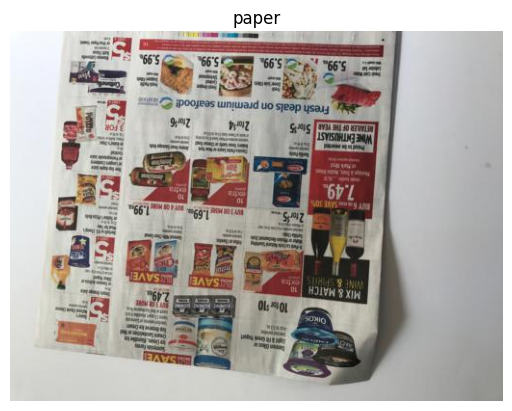

In [8]:
import random
from PIL import Image
import matplotlib.pyplot as plt

cls = random.choice(os.listdir(data_path))
img = random.choice(os.listdir(os.path.join(data_path, cls)))

img_path = os.path.join(data_path, cls, img)

plt.imshow(Image.open(img_path))
plt.title(cls)
plt.axis("off")

In [9]:
import tensorflow as tf

img_size = (224, 224)
batch_size = 32
seed = 42

train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    data_path,
    validation_split=0.2,
    subset="training",
    seed=seed,
    image_size=img_size,
    batch_size=batch_size
)

val_ds = tf.keras.preprocessing.image_dataset_from_directory(
    data_path,
    validation_split=0.2,
    subset="validation",
    seed=seed,
    image_size=img_size,
    batch_size=batch_size
)

class_names = train_ds.class_names
print("Classes:", class_names)

Found 2527 files belonging to 6 classes.
Using 2022 files for training.
Found 2527 files belonging to 6 classes.
Using 505 files for validation.
Classes: ['cardboard', 'glass', 'metal', 'paper', 'plastic', 'trash']


In [10]:
from tensorflow.keras import layers, models

model = models.Sequential([
    layers.Rescaling(1./255, input_shape=(224, 224, 3)),

    layers.Conv2D(32, (3,3), activation='relu'),
    layers.MaxPooling2D(),

    layers.Conv2D(64, (3,3), activation='relu'),
    layers.MaxPooling2D(),

    layers.Conv2D(128, (3,3), activation='relu'),
    layers.MaxPooling2D(),

    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dense(len(class_names), activation='softmax')
])

model.summary()



Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling (Rescaling)       (None, 224, 224, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 222, 222, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2  (None, 111, 111, 32)      0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 109, 109, 64)      18496     
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 54, 54, 64)        0         
 g2D)                                                            
                                                                 
 conv2d_2 (Conv2D)           (None, 52, 52, 128)      

In [11]:
model.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

In [12]:
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=5
)

Epoch 1/5


64/64 [==============================] - 184s 3s/step - loss: 1.8422 - accuracy: 0.3096 - val_loss: 1.5327 - val_accuracy: 0.3842
Epoch 2/5
64/64 [==============================] - 195s 3s/step - loss: 1.3599 - accuracy: 0.4624 - val_loss: 1.3710 - val_accuracy: 0.4158
Epoch 3/5
64/64 [==============================] - 127s 2s/step - loss: 1.1403 - accuracy: 0.5579 - val_loss: 1.1588 - val_accuracy: 0.5208
Epoch 4/5
64/64 [==============================] - 141s 2s/step - loss: 0.9954 - accuracy: 0.6162 - val_loss: 1.2723 - val_accuracy: 0.5208
Epoch 5/5
64/64 [==============================] - 135s 2s/step - loss: 0.7927 - accuracy: 0.7097 - val_loss: 1.1262 - val_accuracy: 0.5881


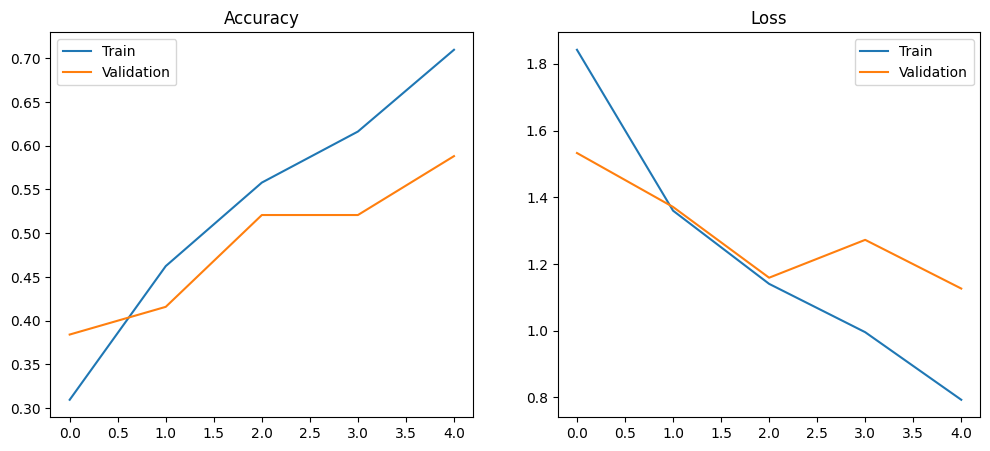

In [13]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12,5))

plt.subplot(1,2,1)
plt.plot(history.history['accuracy'], label='Train')
plt.plot(history.history['val_accuracy'], label='Validation')
plt.title("Accuracy")
plt.legend()

plt.subplot(1,2,2)
plt.plot(history.history['loss'], label='Train')
plt.plot(history.history['val_loss'], label='Validation')
plt.title("Loss")
plt.legend()

plt.show()

1/1 [==============================] - 1s 640ms/step


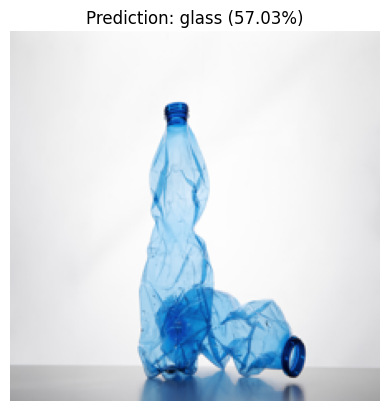

In [15]:
import tensorflow as tf
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt

# path of uploaded image
img_path = "test_plastic.jpg"   # <-- change if needed

# load & preprocess image
img = Image.open(img_path).convert("RGB")
img = img.resize((224, 224))

img_array = np.array(img) / 255.0
img_array = np.expand_dims(img_array, axis=0)

# predict
predictions = model.predict(img_array)
predicted_class = class_names[np.argmax(predictions)]
confidence = np.max(predictions) * 100

# show image
plt.imshow(img)
plt.axis("off")
plt.title(f"Prediction: {predicted_class} ({confidence:.2f}%)")
plt.show()

1/1 [==============================] - 1s 620ms/step


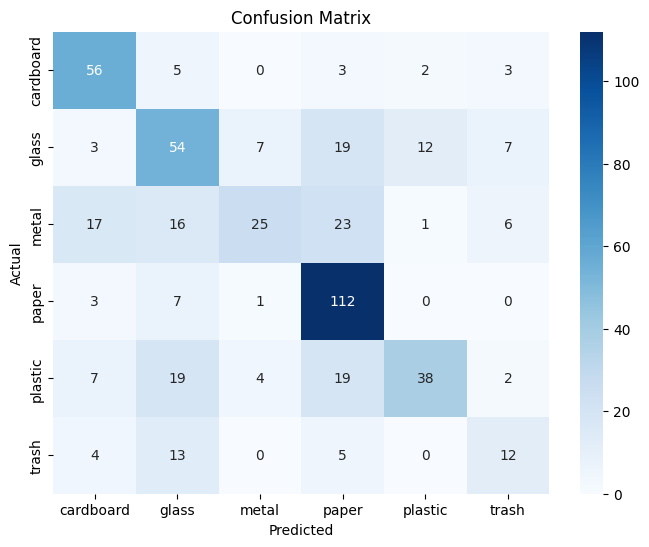

In [18]:
import numpy as np
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
import matplotlib.pyplot as plt

# Get true labels and predictions
y_true = []
y_pred = []

for images, labels in val_ds: # Changed from val_generator to val_ds
    preds = model.predict(images)
    y_true.extend(labels.numpy()) # labels are already integer class IDs
    y_pred.extend(np.argmax(preds, axis=1))

cm = confusion_matrix(y_true, y_pred)

plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=class_names,
            yticklabels=class_names)
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()

In [19]:
model.save("garbage_classifier.h5")

c:\Users\Atharva\RecycleVision\venv\lib\site-packages\keras\src\engine\training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(
